# Preparation

In [ ]:
%pip install datasets
%pip install transformers[torch]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
import pandas as pd

# Read data
# TODO: Change to base_data_path = 'INSERT_PATH'
base_data_path = './drive/MyDrive/Studium_Kempten/Masterarbeit/Azure_Notebooks/Abgabe_Data'
train_df = pd.read_csv(f'{base_data_path}/amazon_ffr_train.csv')
test_df = pd.read_csv(f'{base_data_path}/amazon_ffr_test.csv')

# Reduce train data size because of the limited processing capacity
train_df = train_df[:20000]

# Rename Label column
train_df = train_df.rename(columns={'Sentiment': 'label'})
test_df = test_df.rename(columns={'Sentiment': 'label'})

In [ ]:
train_df

,Text,label
0,I did not like any of the brew over iced tea f...,2
1,My dog loves the nylabone bones and they aren'...,2
2,I bought this set of six cans for about $25--t...,2
3,If you have only tried Indian food in restaura...,0
4,I got the sea salt and vinegar chips from Kett...,2
...,...,...
19995,Starbucks' Vanilla Flavored Ground Coffee soun...,2
19996,"As a newly adopter of a one year old, I tried ...",2
19997,My son loves these cereal bars. I used to be a...,2
19998,Two primary reasons I didn't like this tea:<br...,0


In [ ]:
test_df

,Text,label
0,I've bought Joyva tahini for 4 years and never...,0
1,Before ordering these I exchanged email with t...,0
2,There's not much product in the bag - just ove...,1
3,This is an excellent sugar substitute. It has...,2
4,I have purchased this before and am about to d...,2
...,...,...
9995,Love this tea! I enjoy it with a little bit o...,2
9996,After PetCo stopped making a similar product I...,2
9997,"Great product, but I ordered in August and shi...",2
9998,Picked the Rainforest blend up at a local big ...,0


# Preprocess Data for RoBERTa Model

In [ ]:
# Clean Data
import re
# Remove HTML tags
TAG_RE = re.compile(r'<[^>]+>')

def clean_text(sentence):
  sentence = sentence.lower()
  sentence = TAG_RE.sub('', sentence)
  return sentence

# Apply Cleaning and Lowercasing of the data
train_df['Text'] = train_df['Text'].apply(clean_text)
test_df['Text'] = test_df['Text'].apply(clean_text)

In [ ]:
# Tokenization and Creation of Datasets
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tokenize_function(examples):
   return tokenizer(examples['Text'], padding=True, truncation=True, return_tensors='pt', max_length=512)

train_test_dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'test': Dataset.from_pandas(test_df, preserve_index=False)
})
# Apply Tokenization on training and test data
tokenized_datasets = train_test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# Fine-Tuning of RoBERTa Model

In [ ]:
# Initialize model and define Training Arguments
from transformers import AutoModelForSequenceClassification, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

training_args = TrainingArguments(
  output_dir='./transformers/roberta_model',
  logging_strategy='epoch',
  evaluation_strategy='epoch',
  save_strategy = 'epoch'
)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Definition of the metrics used for evaluation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def display_confusion_matrix(confusion_matrix):
    plt.figure()
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    cm = confusion_matrix(labels, predictions)
    display_confusion_matrix(cm)
    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, output_dict=True)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    return {
        'accuracy': accuracy,
        'precision_weighted': report['weighted avg']['precision'],
        'recall_weighted': report['weighted avg']['recall'],
        'f1_weighted': report['weighted avg']['f1-score'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score'],
    }

Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Macro,Recall Macro,F1 Macro
1,0.399700,0.272548,0.901500,0.894434,0.901500,0.897460,0.740657,0.712443,0.724403
2,0.270500,0.365829,0.904300,0.892588,0.904300,0.895983,0.745000,0.695833,0.709471
3,0.173700,0.409859,0.905800,0.905230,0.905800,0.905512,0.744720,0.742838,0.743767


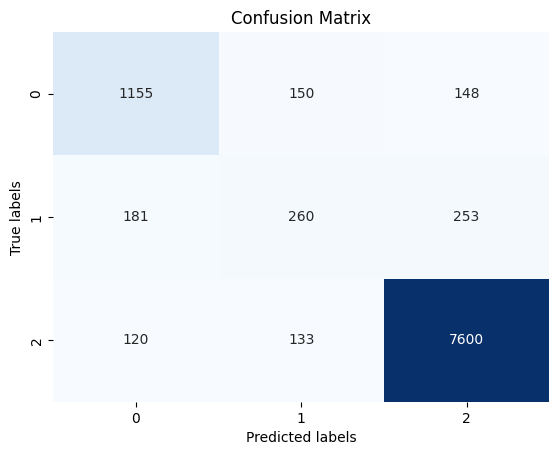

Accuracy: 0.9015
Classification Report:
{'0': {'precision': 0.7932692307692307, 'recall': 0.7949070887818307, 'f1-score': 0.7940873152286009, 'support': 1453}, '1': {'precision': 0.47882136279926335, 'recall': 0.3746397694524496, 'f1-score': 0.42037186742118027, 'support': 694}, '2': {'precision': 0.9498812648418947, 'recall': 0.9677830128613268, 'f1-score': 0.9587485807997982, 'support': 7853}, 'accuracy': 0.9015, 'macro avg': {'precision': 0.7406572861367963, 'recall': 0.7124432903652024, 'f1-score': 0.7244025878165266, 'support': 10000}, 'weighted avg': {'precision': 0.894433979089378, 'recall': 0.9015, 'f1-score': 0.897459955003827, 'support': 10000}}


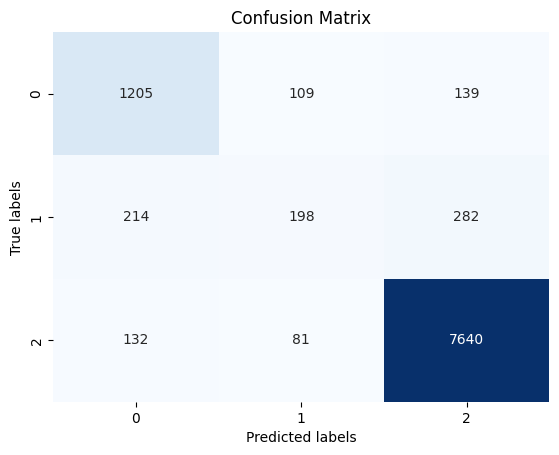

Accuracy: 0.9043
Classification Report:
{'0': {'precision': 0.7769181173436492, 'recall': 0.8293186510667584, 'f1-score': 0.8022636484687083, 'support': 1453}, '1': {'precision': 0.5103092783505154, 'recall': 0.28530259365994237, 'f1-score': 0.36598890942698703, 'support': 694}, '2': {'precision': 0.9477732291278997, 'recall': 0.9728766076658601, 'f1-score': 0.9601608646474802, 'support': 7853}, 'accuracy': 0.9043, 'macro avg': {'precision': 0.7450002082740216, 'recall': 0.695832617464187, 'f1-score': 0.7094711408477252, 'support': 10000}, 'weighted avg': {'precision': 0.8925879832016977, 'recall': 0.9043, 'f1-score': 0.8959828654444023, 'support': 10000}}


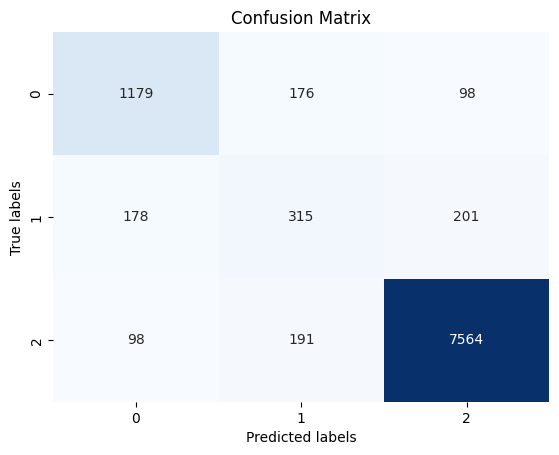

Accuracy: 0.9058
Classification Report:
{'0': {'precision': 0.8103092783505155, 'recall': 0.811424638678596, 'f1-score': 0.8108665749656121, 'support': 1453}, '1': {'precision': 0.46187683284457476, 'recall': 0.4538904899135447, 'f1-score': 0.4578488372093023, 'support': 694}, '2': {'precision': 0.961973801348086, 'recall': 0.9631987775372469, 'f1-score': 0.9625858997200305, 'support': 7853}, 'accuracy': 0.9058, 'macro avg': {'precision': 0.7447199708477253, 'recall': 0.7428379687097958, 'f1-score': 0.7437671039649816, 'support': 10000}, 'weighted avg': {'precision': 0.9052302165423953, 'recall': 0.9058, 'f1-score': 0.9055123296949691, 'support': 10000}}
TrainOutput(global_step=7500, training_loss=0.28132366943359377, metrics={'train_runtime': 6716.6511, 'train_samples_per_second': 8.933, 'train_steps_per_second': 1.117, 'total_flos': 1.578680506368e+16, 'train_loss': 0.28132366943359377, 'epoch': 3.0})
CPU times: user 1h 49min 12s, sys: 1min 6s, total: 1h 50min 18s
Wall time: 1h 52min

In [ ]:
%%time
# Perform Training
from transformers import Trainer
# It took about 1h 52 min Minutes to train on 20.000 training and evaluate 10.000 Test Data for 3 Epochs using a T4 GPU

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

training_result = trainer.train()
print(training_result)

# Evaluation of RoBERTa Model

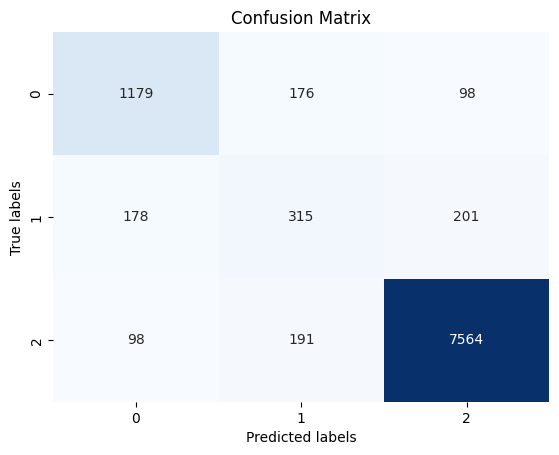

Accuracy: 0.9058
Classification Report:
{'0': {'precision': 0.8103092783505155, 'recall': 0.811424638678596, 'f1-score': 0.8108665749656121, 'support': 1453}, '1': {'precision': 0.46187683284457476, 'recall': 0.4538904899135447, 'f1-score': 0.4578488372093023, 'support': 694}, '2': {'precision': 0.961973801348086, 'recall': 0.9631987775372469, 'f1-score': 0.9625858997200305, 'support': 7853}, 'accuracy': 0.9058, 'macro avg': {'precision': 0.7447199708477253, 'recall': 0.7428379687097958, 'f1-score': 0.7437671039649816, 'support': 10000}, 'weighted avg': {'precision': 0.9052302165423953, 'recall': 0.9058, 'f1-score': 0.9055123296949691, 'support': 10000}}
{'eval_loss': 0.4098585844039917, 'eval_accuracy': 0.9058, 'eval_precision_weighted': 0.9052302165423953, 'eval_recall_weighted': 0.9058, 'eval_f1_weighted': 0.9055123296949691, 'eval_precision_macro': 0.7447199708477253, 'eval_recall_macro': 0.7428379687097958, 'eval_f1_macro': 0.7437671039649816, 'eval_runtime': 310.549, 'eval_sample

In [ ]:
# If you only want to evaluate a model without Fine-Tuning it, you can directly call trainer.evaluate()
evaluation_result = trainer.evaluate()
print(evaluation_result)

In [ ]:
# Save the trained model
model_path = "./transformers/roberta_model_pytorch_20000_training_saved"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./transformers/roberta_model_pytorch_20000_training_saved/tokenizer_config.json',
 './transformers/roberta_model_pytorch_20000_training_saved/special_tokens_map.json',
 './transformers/roberta_model_pytorch_20000_training_saved/vocab.json',
 './transformers/roberta_model_pytorch_20000_training_saved/merges.txt',
 './transformers/roberta_model_pytorch_20000_training_saved/added_tokens.json',
 './transformers/roberta_model_pytorch_20000_training_saved/tokenizer.json')

In [ ]:
# You can load the saved model by using:
from transformers import RobertaForSequenceClassification, AutoTokenizer
model_path = "./transformers/roberta_model_pytorch_20000_training_saved"
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             